In [114]:
# --- General ---
import os
from datetime import datetime

# --- Data ---
import pandas as pd
from pandasql import sqldf
import numpy as np
import statistics as stats
import json 

# --- Conexión ---
import elasticsearch

# --- Procesamiento lenguaje: spacy ---
# import spacy
# from spacy.matcher import Matcher
# from spacy.matcher import PhraseMatcher

# --- Procesamiento lenguaje: gensim ---
# import gensim
# import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
# from gensim.models import CoherenceModel

# --- Visualización ---
# import pyLDAvis
# import pyLDAvis.gensim_models  # don't skip this
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Colormap, ListedColormap
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

# ==============================================================================

# --- Configuración ---
# User password
password = os.environ.get('SOPHIA2')

# geoData
# read json regiones_comunas_format
with open('./regiones_comunas/regiones_comunas_format.json') as f:
    regiones = json.load(f)
    regiones = regiones['regiones']

# --- Funciones ---
# Cargar paquete de español mediano
# nlp = spacy.load("es_core_news_md")

In [115]:
def list_regions(regiones):
    '''
    Parameters:
        regiones (list of dict): lista de regiones [{region: 'region', comunas: ['comuna1', 'comuna2', ...]}]
    Return (void)
        Lista con los nombres de las regiones'''
    for r in regiones:
        print(r['region'])

def search_region(region):
    '''
    Parameters:
        region (str): nombre de la región a buscar
    Return (region: [{region: 'region', comunas: ['comuna1','comuna2']}] ) or (None):
        Lista dict con la region y comunas de la región'''
    
    # Buscar región, ejemplo: 'Arica y Parinacota' o 'Arica_y_Parinacota '
    region = region.replace(' ', '_')

    for data_region in regiones:
        if data_region['region'] == region:
            print('Region encontrada')
            return data_region
    print('Region no encontrada')
    return None

data_regiones_comunas = search_region('Región_de_Los_Lagos')
if(data_regiones_comunas):
    region = data_regiones_comunas['region']
    comunas = data_regiones_comunas['comunas']

Region encontrada


In [116]:
# {nombre_archivo}_{from_}_{to_}_{dominant_topic}.csv
nombre_archivo = 'data_Region_X_2022-01-01_2022-01-07_dominant_topic'
# nombre_archivo = 'data_Region_X_2022-01-01_2022-01-31_dominant_topic'

### Cargamos los datos de comunas con ñ y acentos

In [117]:
# Fixeamos el error mencionado de lectura, para tildes y ñ: utilizamos encoding = 'utf-8
territory = gpd.read_file(r'./regiones_comunas/shape/comunas.shp', encoding='utf-8')
territory

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731...."
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596...."
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.357 -4060673.364, -7892621...."
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-7906457.717 -4051723.734, -7906266...."
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644...."
...,...,...,...,...,...,...,...,...,...,...,...,...
341,255,130240.555805,19,10,16305,16,8.751006e+08,160459.137929,Región de Ñuble,San Nicolás,Punilla,"POLYGON ((-8041950.854 -4349201.562, -8041735...."
342,253,311061.932415,19,10,16304,16,2.393007e+09,388109.613857,Región de Ñuble,San Fabián,Punilla,"POLYGON ((-7931328.549 -4363544.179, -7931320...."
343,245,159257.906431,19,10,16303,16,7.638173e+08,195593.933727,Región de Ñuble,Ñiquén,Punilla,"POLYGON ((-8026032.185 -4319505.012, -8025933...."
344,243,157467.049667,19,10,16104,16,1.044405e+09,196962.664313,Región de Ñuble,El Carmen,Ñuble,"POLYGON ((-7986315.104 -4415272.935, -7986309...."


#

### Filtramos por código de Región 10 (Región de Los Lagos)

In [118]:
territory = territory[territory["codregion"] == 10]
territory

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
29,133,1.828414e+05,25,13,10307,10,1.087024e+09,2.400442e+05,Región de Los Lagos,San Pablo,Osorno,"POLYGON ((-8174316.930 -4910454.843, -8174109...."
50,113,7.248812e+04,26,13,10206,10,1.761007e+08,9.842672e+04,Región de Los Lagos,Puqueldón,Chiloe,"POLYGON ((-8192405.306 -5246776.357, -8192341...."
51,120,2.626703e+05,25,13,10104,10,2.252031e+09,3.438808e+05,Región de Los Lagos,Fresia,Llanquihue,"MULTIPOLYGON (((-8226493.287 -5038106.271, -82..."
52,122,1.196095e+05,25,13,10107,10,7.650549e+08,1.663208e+05,Región de Los Lagos,Llanquihue,Llanquihue,"POLYGON ((-8161909.969 -5031493.581, -8161797...."
53,127,2.561505e+05,25,13,10301,10,1.656162e+09,3.372027e+05,Región de Los Lagos,Osorno,Osorno,"POLYGON ((-8162032.045 -4927188.771, -8161590...."
54,129,3.460363e+05,25,13,10303,10,2.544876e+09,4.600232e+05,Región de Los Lagos,Purranque,Osorno,"MULTIPOLYGON (((-8230523.146 -5021107.349, -82..."
143,130,3.071611e+05,25,13,10304,10,2.828856e+09,4.132961e+05,Región de Los Lagos,Puyehue,Osorno,"POLYGON ((-8059447.410 -4961786.325, -8057948...."
148,119,5.734616e+05,26,13,10103,10,7.058709e+09,7.852759e+05,Región de Los Lagos,Cochamó,Llanquihue,"MULTIPOLYGON (((-8080034.316 -5118383.675, -80..."
161,342,5.968358e+05,26,13,10202,10,3.214864e+09,6.697127e+05,Región de Los Lagos,Ancud,Chiloe,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82..."
162,115,8.849777e+05,26,13,10208,10,6.296142e+09,1.211081e+06,Región de Los Lagos,Quellón,Chiloe,"MULTIPOLYGON (((-8331772.949 -5403679.835, -83..."


### Conservamos 'Comuna' y 'Geometry'

In [119]:
territory = territory[["Comuna", "geometry"]]
# Creamos coords de referencia
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
territory['coords'] = territory['geometry'].apply(lambda x: x.representative_point().coords[:]);
territory['coords'] = [coords[0] for coords in territory['coords']];

# Dataframes que utilizaremos
territory_menciones = territory.copy() # copia que se utilizará para menciones
territory_topicos = territory.copy() # copia que se utilizará para topico
territory_positividad = territory.copy() # copia que se utilizará para positividad
territory

/home/alex/miniconda3/envs/myenv/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Comuna,geometry,coords
29,San Pablo,"POLYGON ((-8174316.930 -4910454.843, -8174109....","(-8139435.113425187, -4927836.14285)"
50,Puqueldón,"POLYGON ((-8192405.306 -5246776.357, -8192341....","(-8198665.986698143, -5257163.701000001)"
51,Fresia,"MULTIPOLYGON (((-8226493.287 -5038106.271, -82...","(-8193670.726446506, -5034990.0834)"
52,Llanquihue,"POLYGON ((-8161909.969 -5031493.581, -8161797....","(-8138332.2775472775, -5045007.35475)"
53,Osorno,"POLYGON ((-8162032.045 -4927188.771, -8161590....","(-8140053.108083981, -4954148.655649999)"
54,Purranque,"MULTIPOLYGON (((-8230523.146 -5021107.349, -82...","(-8172850.314287778, -5002634.2157499995)"
143,Puyehue,"POLYGON ((-8059447.410 -4961786.325, -8057948....","(-8058403.366813047, -4969781.3531)"
148,Cochamó,"MULTIPOLYGON (((-8080034.316 -5118383.675, -80...","(-8036501.702345301, -5124182.419399999)"
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...","(-8216686.860888084, -5162692.993100001)"
162,Quellón,"MULTIPOLYGON (((-8331772.949 -5403679.835, -83...","(-8240214.84870591, -5331248.85495)"


### Descargamos los archivos de comunas

In [120]:
df = pd.read_csv('./data/'+nombre_archivo+'.csv', encoding='utf-8')
df.head(3)

,document_No,dominant_Topic,topic_Perc_Contrib,keywords,text,id_news,country,media_outlet,url,title,...,Frutillar,Fresia,Dalcahue,Curaco_de_Vélez,Cochamó,Chonchi,Chaitén,Castro,Calbuco,Ancud
0,0,5,0.9766,"trabajadores, salud, empresas, día, año, perso...",Así lo confirmó la autoridad sanitaria detalla...,21908558.0,chile,radiosago,https://www.radiosago.cl/140-contagios-de-covi...,140 contagios de covid-19 se reportaron este j...,...,1,1,1,0,0,1,0,1,1,1
1,1,6,0.9164,"mascarilla, comunidad, días, respecto, trabajo...",Una Alerta Temprana Preventiva por tormentas e...,21908579.0,chile,radiosago,https://www.radiosago.cl/por-tormentas-electri...,Por tormentas eléctricas declaran alerta en cu...,...,0,0,0,0,0,0,0,0,0,0
2,2,7,0.9956,"proyecto, comunidad, comuna, años, personas, a...","Patricio Vallespin, gobernador regional de Los...",21909623.0,chile,radiosago,https://www.radiosago.cl/gobernador-vallespin-...,Gobernador Vallespin llamó a construir entre t...,...,0,0,0,0,0,0,0,0,0,0


### Ordenamos las comunas y creamos la petición en sqldf

In [121]:
petitionSQLDF  = 'SELECT '
for comuna in comunas :
    # Si encuentra un espacio entonces añade corchetes para la petición en mysql
    if comuna.find(' ') > 0 :
        petitionSQLDF = petitionSQLDF+('sum(['+comuna+']), ')
    else :
        petitionSQLDF = petitionSQLDF+('sum('+comuna+'), ')

petitionSQLDF = petitionSQLDF[:-2] # eliminamos la última coma
petitionSQLDF = petitionSQLDF+' FROM df'
petitionSQLDF

'SELECT sum(Ancud), sum(Calbuco), sum(Castro), sum(Chaitén), sum(Chonchi), sum(Cochamó), sum(Curaco_de_Vélez), sum(Dalcahue), sum(Fresia), sum(Frutillar), sum(Futaleufú), sum(Hualaihué), sum(Llanquihue), sum(Los_Muermos), sum(Maullín), sum(Osorno), sum(Palena), sum(Puerto_Montt), sum(Puerto_Octay), sum(Puerto_Varas), sum(Puqueldón), sum(Purranque), sum(Puyehue), sum(Queilén), sum(Quellón), sum(Quemchi), sum(Quinchao), sum(Río_Negro), sum(San_Juan_de_la_Costa), sum(San_Pablo) FROM df'

### Filtramos por cantidad de menciones totales 

In [122]:
result = sqldf(petitionSQLDF)
result

,sum(Ancud),sum(Calbuco),sum(Castro),sum(Chaitén),sum(Chonchi),sum(Cochamó),sum(Curaco_de_Vélez),sum(Dalcahue),sum(Fresia),sum(Frutillar),...,sum(Puqueldón),sum(Purranque),sum(Puyehue),sum(Queilén),sum(Quellón),sum(Quemchi),sum(Quinchao),sum(Río_Negro),sum(San_Juan_de_la_Costa),sum(San_Pablo)
0,20,20,28,8,9,7,5,10,9,7,...,5,11,8,2,17,4,14,6,2,4


In [123]:
values = result.values[0] # esto contiene los valores de sumas de cada comuna

# Añadimos los datos filtrados anteriormente
territory_menciones = territory_menciones.sort_values(by=['Comuna']) # ordenamos alfabéticamente
territory_menciones['values'] = values # añadimos los valores de sumas de cada comuna

# Creamos coords de referencia
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
# territory_menciones['coords'] = territory_menciones['geometry'].apply(lambda x: x.representative_point().coords[:])
# territory_menciones['coords'] = [coords[0] for coords in territory_menciones['coords']]
territory_menciones.head(3)

,Comuna,geometry,coords,values
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...","(-8216686.860888084, -5162692.993100001)",20
254,Calbuco,"MULTIPOLYGON (((-8112967.653 -5147692.027, -81...","(-8148106.117221469, -5115110.540750001)",20
167,Castro,"MULTIPOLYGON (((-8171095.068 -5254002.891, -81...","(-8227801.498338105, -5230294.630800001)",28


### Con los datos listos, podemos graficar el numero de menciones hacia cada comuna

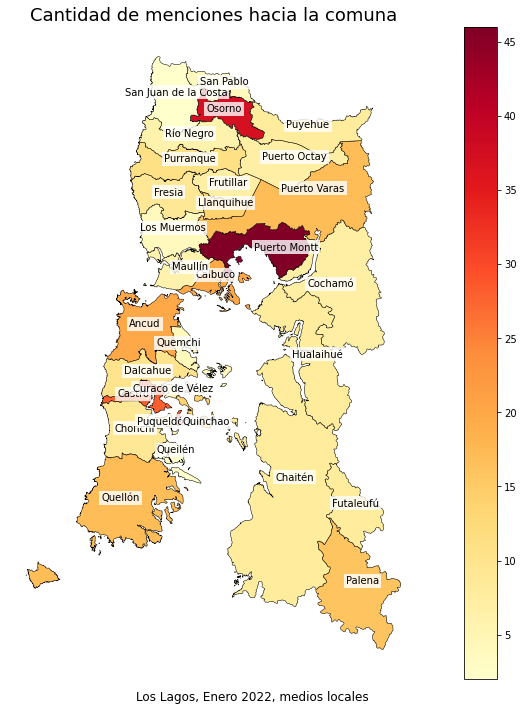

In [124]:
# Graficamos los datos
territory_menciones.plot(column="values", legend=True, figsize=(16, 12), cmap="YlOrRd", edgecolor="black", linewidth=0.5).set_axis_off();
# Información
plt.title("Cantidad de menciones hacia la comuna", fontsize=18);

for idx, row in territory_menciones.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(0.6, 0.1, "Los Lagos, Enero 2022, medios locales", fontsize=12, ha='center', transform=plt.gcf().transFigure);

### Grafico mapa por topico relevante

In [125]:
# Copia distinta del df
df_topics = df.copy()

In [126]:
def get_moda_list(lista):
    '''
    Parameters:
        lista (list): lista de valores
    Return (int):
        moda1, moda2, porcentaje1'''
    li = lista.copy()
    try: 
        moda = stats.mode(li)
    except:
        return np.NaN, np.NaN, np.NaN

    perc_1 = 0
    while (li.count(moda)):
        perc_1 = perc_1 + 1
        li.remove(moda)
    
    perc_1 = float(perc_1 / len(lista))

    try:
        moda2 = stats.mode(li)
    except:
        return moda, np.NaN, perc_1

    return moda, moda2, perc_1


In [127]:
# Creamos un df nuevo que contenga como filas los nombres de comunas y com fila [topico_mas_relevante, segundo_topico_mas_relevante]
df_comunas = pd.DataFrame(columns=['topic_1','perc_1','keywords_1' ,'topic_2','keywords_2' , 'total_noticias'], index=comunas)
df_comunas

,topic_1,perc_1,keywords_1,topic_2,keywords_2,total_noticias
Ancud,NaN,NaN,NaN,NaN,NaN,NaN
Calbuco,NaN,NaN,NaN,NaN,NaN,NaN
Castro,NaN,NaN,NaN,NaN,NaN,NaN
Chaitén,NaN,NaN,NaN,NaN,NaN,NaN
Chonchi,NaN,NaN,NaN,NaN,NaN,NaN
Cochamó,NaN,NaN,NaN,NaN,NaN,NaN
Curaco_de_Vélez,NaN,NaN,NaN,NaN,NaN,NaN
Dalcahue,NaN,NaN,NaN,NaN,NaN,NaN
Fresia,NaN,NaN,NaN,NaN,NaN,NaN
Frutillar,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
# max df dominant topic
max_topics = df_topics['dominant_Topic'].max()
print(f'Maximo de topicos {max_topics+1}')

# Contabilizamos las apariciones de cada comuna
for comuna in comunas:
    petitionSQLDF = 'SELECT dominant_Topic, keywords, text, '+comuna+' FROM df_topics WHERE '+comuna+'>0'
    result = sqldf(petitionSQLDF)
    # --- Una vez que hicimos la consulta por comuna ---

    # -- Tomamos los valores de topicos --
    topicos = list(result['dominant_Topic'].values)
    # -- Calculamos la moda_1, moda_2 y porcentaje_1 --
    moda1, moda2, perc_1 = get_moda_list(topicos)

    try:
        # -- Intentamos obtener los keywords de la moda_1 --
        keyword_1 = result[result['dominant_Topic'] == moda1]['keywords'].values[0]
    except:
        keyword_1 = ''

    try:
        # -- Intentamos obtener los keywords de la moda_2 --
        keyword_2 = result[result['dominant_Topic'] == moda2]['keywords'].values[0]
    except:
        keyword_2 = ''
    # print (moda1, perc_1, keyword_1, moda2, keyword_2, len(topicos))
    df_comunas.loc[comuna] = [moda1, perc_1, keyword_1, moda2, keyword_2, len(topicos)+1]

Maximo de topicos 8


In [129]:
df_comunas

,topic_1,perc_1,keywords_1,topic_2,keywords_2,total_noticias
Ancud,7,0.35,"proyecto, comunidad, comuna, años, personas, a...",5,"trabajadores, salud, empresas, día, año, perso...",21
Calbuco,3,0.25,"centro, escape, parte, servicio, comuna, peces...",5,"trabajadores, salud, empresas, día, año, perso...",21
Castro,7,0.392857,"proyecto, comunidad, comuna, años, personas, a...",3,"centro, escape, parte, servicio, comuna, peces...",29
Chaitén,7,0.375,"proyecto, comunidad, comuna, años, personas, a...",2,"años, tiempo, poesía, año, variante, manera, s...",9
Chonchi,5,0.444444,"trabajadores, salud, empresas, día, año, perso...",6,"mascarilla, comunidad, días, respecto, trabajo...",10
Cochamó,0,0.571429,"resultados, ingresos, beneficios, créditos, ed...",7,"proyecto, comunidad, comuna, años, personas, a...",8
Curaco_de_Vélez,1,0.4,"año, arte, firmas, mundo, fin, pandemia, fin d...",5,"trabajadores, salud, empresas, día, año, perso...",6
Dalcahue,5,0.3,"trabajadores, salud, empresas, día, año, perso...",7,"proyecto, comunidad, comuna, años, personas, a...",11
Fresia,5,0.444444,"trabajadores, salud, empresas, día, año, perso...",7,"proyecto, comunidad, comuna, años, personas, a...",10
Frutillar,5,0.571429,"trabajadores, salud, empresas, día, año, perso...",1,"año, arte, firmas, mundo, fin, pandemia, fin d...",8


In [130]:
# get topic 1 and perc_1 como lista
topic_1 = list(df_comunas['topic_1'].values)
topic_2 = list(df_comunas['topic_2'].values)
perc_1 = list(df_comunas['perc_1'].values)
print(topic_1);print(perc_1)

[7, 3, 7, 7, 5, 0, 1, 5, 5, 5, 4, 5, 5, 5, 5, 7, 5, 7, 5, 5, 7, 5, 4, 7, 5, 5, 7, 5, 5, 5]
[0.35, 0.25, 0.39285714285714285, 0.375, 0.4444444444444444, 0.5714285714285714, 0.4, 0.3, 0.4444444444444444, 0.5714285714285714, 0.5, 0.375, 0.35714285714285715, 0.5, 0.5, 0.24324324324324326, 0.4375, 0.21739130434782608, 0.42857142857142855, 0.35294117647058826, 0.4, 0.45454545454545453, 0.375, 1.0, 0.29411764705882354, 0.5, 0.2857142857142857, 0.5, 0.5, 0.5]


In [131]:
topic_1 = pd.array(topic_1, dtype=pd.Int64Dtype())
topic_2 = pd.array(topic_2, dtype=pd.Int64Dtype()) # evitamos el nan

territory_topicos['topic_1'] = topic_1
territory_topicos['topic_2'] = topic_2 # pasamos a int
territory_topicos['percentage'] = perc_1

# agregamos una columna de colores para cada topico
colors_ = ['#ff6961','#ffb480','#f8f38d', '#42d6a4','#08cad1','#59adf6','#9d94ff','#c780e8']

# add color and if its nan then white
territory_topicos['color_1'] = territory_topicos['topic_1'].apply(lambda x: colors_[int(x)] if not pd.isna(x) else '#ffffff')
territory_topicos['color_2'] = territory_topicos['topic_2'].apply(lambda x: colors_[int(x)] if not pd.isna(x) else '#ffffff')

In [132]:
# color dict 
color_dict = {i : colors_[i] for i in range(len(colors_))}

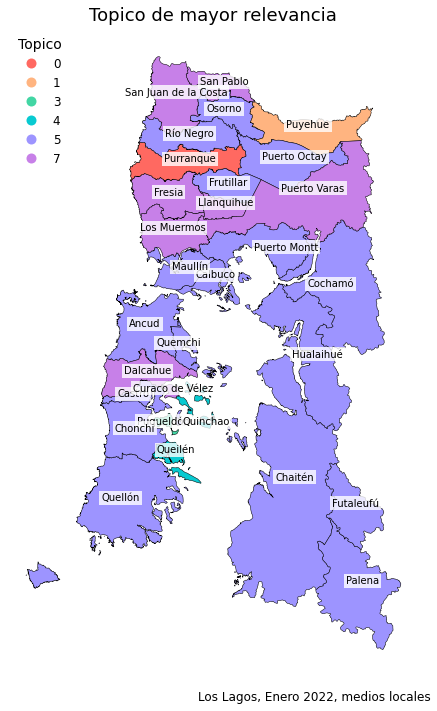

In [133]:
# Graficamos los datos
territory_topicos.plot(column="topic_1", cmap=colors.ListedColormap(list(color_dict.values())), legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5, categorical=True,
legend_kwds={
        'title': 'Topico',
        'loc': 'upper left',
        'fontsize': 12,
        'title_fontsize': 14,
        'frameon': False,
        'facecolor': 'white',
        'edgecolor': 'white',
        'shadow': False
},
missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'red',
        'label': 'Missing values',
}).set_axis_off();
# Información
plt.title("Topico de mayor relevancia", fontsize=18);

for idx, row in territory_topicos.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(0.6, 0.1, "Los Lagos, Enero 2022, medios locales", fontsize=12, ha='center', transform=plt.gcf().transFigure);

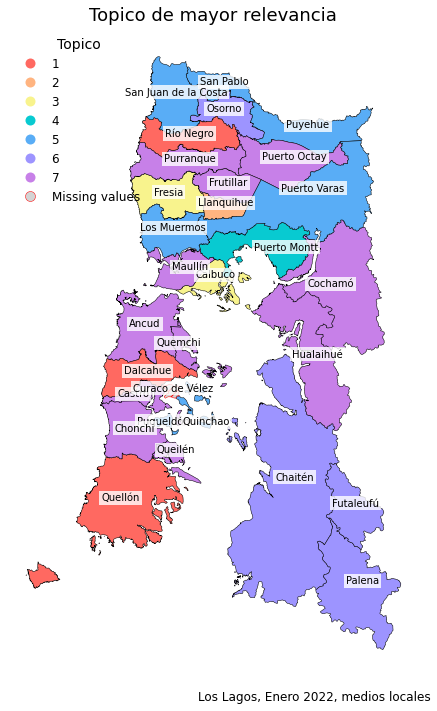

In [134]:
# Graficamos los datos
territory_topicos.plot(column="topic_2", cmap=colors.ListedColormap(list(color_dict.values())), legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5, categorical=True,
legend_kwds={
        'title': 'Topico',
        'loc': 'upper left',
        'fontsize': 12,
        'title_fontsize': 14,
        'frameon': False,
        'facecolor': 'white',
        'edgecolor': 'white',
        'shadow': False
},
missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'red',
        'label': 'Missing values',
}).set_axis_off();


# Información
plt.title("Topico de mayor relevancia", fontsize=18);

for idx, row in territory_topicos.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(0.6, 0.1, "Los Lagos, Enero 2022, medios locales", fontsize=12, ha='center', transform=plt.gcf().transFigure);